In [237]:
# MNIST with an MLP, from scratch

# - Step 1: build an MLP from scratch to solve MNIST. Question set: https://fleuret.org/dlc/materials/dlc-practical-3.pdf
# - Step 2: debug your network with backprop ninja and a reference implementation using torch's .backward()
# - Step 3: build the same MLP but will full pytorch code (nn.Linear, etc.)

In [238]:
import math
import torch
from torch import nn
import matplotlib.pyplot as plt
%matplotlib inline

In [239]:
from utils import load_data

In [240]:
train_input, train_target, test_input, test_target = load_data(one_hot_labels = True, normalize = True)

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


In [241]:
type(train_input)
train_input.shape

torch.Size([1000, 784])

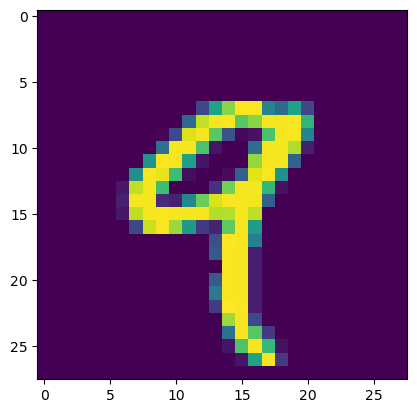

In [242]:
plt.imshow(train_input[4].view((28,28)))
plt.show()

In [243]:
def compute_accuracy (preds, targets):
    """ Computes the accuracy between predictions and targets. Data is expected to be one-hot encoded. """
    _, idx1 = torch.max(preds, dim=1)
    _, idx2 = torch.max(targets, dim=1)
    d = idx1 == idx2
    return d.int().float().mean().item()

In [244]:
# unit test
# this cell should return 0.75
preds = torch.zeros((4,7))
preds[0,1] = 1
preds[1,4] = 1
preds[2,2] = 1
preds[3,6] = 1
targets = torch.zeros((4,7))
targets[0,1] = 1
targets[1,4] = 1
targets[2,2] = 1
targets[3,2] = 1
compute_accuracy(preds, targets)

0.75

In [245]:
def sigma(x):
    expx=torch.exp(x)
    expx=torch.pow(expx, 2)
    num=expx - torch.ones(x.shape)
    den= expx + torch.ones(x.shape)
    den= torch.pow(den, -1)
    return torch.mul(num, den)

def dsigma(x):
    tanh=torch.tanh(x)
    pow=torch.pow(tanh, 2)
    return torch.add(1,-pow)

In [246]:
def loss (v,t):
    diff=torch.add(v,-t)
    pow= torch.pow(diff,2)
    return torch.sum(pow)

def dloss(v,t):
    diff = torch.add(v,-t)
    return torch.mul(2, diff)


In [247]:
# sanity check
v = torch.randn((3, 6), dtype=torch.float32)
t = torch.randn((3, 6), dtype=torch.float32)
l=loss(v,t)
dl=dloss(v,t)
print(l,dl.shape)

tensor(54.2815) torch.Size([3, 6])


In [248]:
# multiply targets by 0.9 to be in the range of tanh
train_target *= 0.9
test_target *= 0.9

### Step 1: Backprop ninja

In [249]:
# utility function we will use later when comparing manual gradients to PyTorch gradients
# DO NOT MODIFY IT
#
def cmp(s, dt, t):
  ex = torch.all(dt == t.grad).item()
  app = torch.allclose(dt, t.grad)
  maxdiff = (dt - t.grad).abs().max().item()
  print(f'{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}')

In [250]:
torch.manual_seed(1337)
w1 = torch.zeros(784,50)
b1 = torch.zeros(50)
w2 = torch.zeros(50,10)
b2 = torch.zeros(10)
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad = True

In [251]:
x1 = train_input[:5]
y1 = train_target[:5]
z1 = x1@w1 + b1
h1 = sigma(z1)
z2 = h1@w2 + b2
h2 = sigma(z2)
l = loss(h2, y1)
h2.shape, l

(torch.Size([5, 10]), tensor(4.0500, grad_fn=<SumBackward0>))

In [252]:
# Force pytorch to retain grade for intermediate nodes and reset grad for parameters
# DO NOT MODIFY THIS CODE
#
others = [h2,z2,h1,z1]
for p in parameters:
    p.grad = None
for t in others:
    t.retain_grad()
l.backward()
print(f'loss={l}')

loss=4.049999713897705


In [253]:
# here we compare our gradient to the reference gradient computed by pytorch
dl = 1.0
dh2 = dloss(h2,y1)*dl
cmp('h2',dh2,h2)
dz2 = dsigma(z2)*dh2
cmp('z2',dz2, z2)
dw2 = h1.T@ dz2
cmp('w2',dw2, w2)
db2 = dz2.sum(axis=0, keepdim=True)
cmp('b2',db2, b2)
dh1 = dz2@w2.T
cmp('h1',dh1, h1)
dz1 = dsigma(z1)*dh1
cmp('z1', dz1, z1)
dw1 = x1.T@dz1
cmp('w1', dw1, w1)
db1 = dz1.sum(axis=0, keepdim=True)
cmp('b1', db1, b1)


h2              | exact: True  | approximate: True  | maxdiff: 0.0
z2              | exact: True  | approximate: True  | maxdiff: 0.0
w2              | exact: True  | approximate: True  | maxdiff: 0.0
b2              | exact: True  | approximate: True  | maxdiff: 0.0
h1              | exact: True  | approximate: True  | maxdiff: 0.0
z1              | exact: True  | approximate: True  | maxdiff: 0.0
w1              | exact: True  | approximate: True  | maxdiff: 0.0
b1              | exact: True  | approximate: True  | maxdiff: 0.0


In [254]:
lr = 0.1
with torch.no_grad():
    w1 += -lr * dw1
    b1 += -lr * db1.squeeze()
    w2 += -lr * dw2
    b2 += -lr * db2.squeeze()

In [255]:
l = loss(h2, y1)
l.item()

4.049999713897705

##### Now that we've checked our gradients are correct, we can implement the network

In [256]:
def forward(w1, b1, w2, b2, x1):
    z1 = x1@w1 + b1
    h1 = sigma(z1)
    z2 = h1@w2 + b2
    h2 = sigma(z2)
    return z1, h1, z2, h2


In [257]:
def backward(w1, b1, w2, b2, x1, y1, h2, z2, h1, z1):
    dl = 1.0
    dh2 = dloss(h2,y1)*dl
    dz2 = dsigma(z2)*dh2
    dw2 = h1.T@ dz2
    db2 = dz2.sum(axis=0, keepdim=True)
    dh1 = dz2@w2.T
    dz1 = dsigma(z1)*dh1
    dw1 = x1.T@dz1
    db1 = dz1.sum(axis=0, keepdim=True)
    return dw1, db1, dw2, db2

In [258]:
def update(w1, b1, w2, b2, dw1, db1, dw2, db2, lr):
    with torch.no_grad():
        w1 += -lr*dw1
        b1 += -lr*db1.squeeze()
        w2 += -lr*dw2
        b2 += -lr*db2.squeeze()
    return w1, b1, w2, b2

In [ ]:
torch.manual_seed(123)
def init():
    """ init a network """
    w1 = torch.randn(784,50)*1.e-6
    b1 = torch.zeros(50)
    w2 = torch.randn(50,10)*1.e-6
    b2 = torch.zeros(10)
    return w1, b1, w2, b2

In [268]:
w1, b1, w2, b2 = init()
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad_(True)

In [269]:
# main training loop
torch.set_printoptions(linewidth=200)
def train(w1, b1, w2, b2):
    lossi = []
    for step in range(10000):
        xb = train_input
        yb = train_target
        num_samples = xb.shape[0]
        # forward
        z1, h1, z2, h2 = forward(w1, b1, w2, b2, xb)
        lsi = loss(h2, yb)
        # backward
        dw1, db1, dw2, db2 = backward(w1, b1, w2, b2, xb, yb, h2, z2, h1, z1)
        # update
        lr = 0.1 / num_samples if step < 5000 else 0.01 / num_samples
        w1, b1, w2, b2 = update(w1, b1, w2, b2, dw1, db1, dw2, db2, lr)
        if step % 100 == 0: print(f'step = {step}, loss = {lsi}')
        lossi.append(lsi.item())
    # compute accuracy
    _, _, _, preds = forward(w1, b1, w2, b2, train_input)
    train_accuracy = compute_accuracy(preds, train_target)
    _, _, _, preds = forward(w1, b1, w2, b2, test_input)
    test_accuracy = compute_accuracy(preds, test_target)
    print(f'{train_accuracy=}')
    print(f'{test_accuracy=}')
    return lossi
    

In [270]:
lossi = train(w1, b1, w2, b2)

step = 0, loss = 806.8902587890625
step = 100, loss = 275.1745910644531
step = 200, loss = 175.6736602783203
step = 300, loss = 117.40237426757812
step = 400, loss = 130.06094360351562
step = 500, loss = 96.46692657470703
step = 600, loss = 88.86346435546875
step = 700, loss = 89.93574523925781
step = 800, loss = 53.007171630859375
step = 900, loss = 48.145694732666016
step = 1000, loss = 54.5289421081543
step = 1100, loss = 53.30002212524414
step = 1200, loss = 49.19352722167969
step = 1300, loss = 29.74117660522461
step = 1400, loss = 37.51118087768555
step = 1500, loss = 39.38268280029297
step = 1600, loss = 27.766029357910156
step = 1700, loss = 35.29481506347656
step = 1800, loss = 27.51020050048828
step = 1900, loss = 21.471664428710938
step = 2000, loss = 23.99175453186035
step = 2100, loss = 23.435049057006836
step = 2200, loss = 33.15193557739258
step = 2300, loss = 28.17558479309082
step = 2400, loss = 26.528959274291992
step = 2500, loss = 18.121530532836914
step = 2600, los

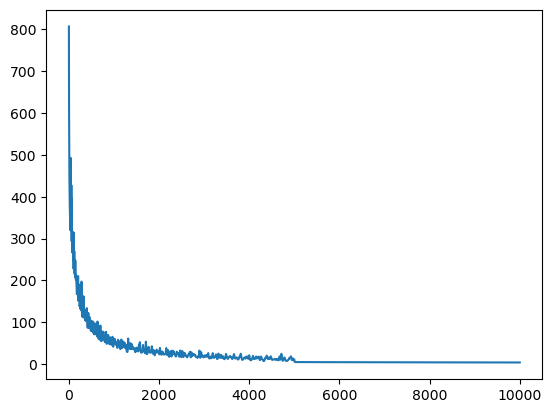

In [271]:
plt.plot(lossi)
plt.show()

### Step 2: Reference implementation using pytorch's .backward()
Nothing to do in Step 2, this code is provided for you as a reference

In [272]:
w1, b1, w2, b2 = init()
parameters = [w1, b1, w2, b2]
for p in parameters:
    p.requires_grad_(True)

In [273]:
# reference code
torch.set_printoptions(linewidth=200)
import torch.nn as F

def train(w1, b1, w2, b2):
    lossi = []
    for step in range(10000):
        xb = train_input
        yb = train_target
        num_samples = xb.shape[0]
        # forward
        z1, h1, z2, h2 = forward(w1, b1, w2, b2, xb)
        xloss = F.MSELoss()
        lsi = xloss(h2, yb) * yb.nelement()
        # backward
        for p in parameters:
            p.grad = None
        lsi.backward()
        # update
        lr = 0.1 / num_samples
        for p in parameters:
            p.data += -lr * p.grad
        if step % 100 == 0: print(f'step = {step}, loss = {lsi}')
        lossi.append(lsi.item())
    # compute accuracy
    _, _, _, preds = forward(w1, b1, w2, b2, train_input)
    train_accuracy = compute_accuracy(preds, train_target)
    _, _, _, preds = forward(w1, b1, w2, b2, test_input)
    test_accuracy = compute_accuracy(preds, test_target)
    print(f'{train_accuracy=}')
    print(f'{test_accuracy=}')
    return lossi

In [274]:
lossi = train(w1, b1, w2, b2)

step = 0, loss = 805.0676879882812
step = 100, loss = 287.4081726074219
step = 200, loss = 164.582275390625
step = 300, loss = 134.50027465820312
step = 400, loss = 127.32785034179688
step = 500, loss = 86.99598693847656
step = 600, loss = 80.18486785888672
step = 700, loss = 62.054039001464844
step = 800, loss = 65.49109649658203
step = 900, loss = 59.25022506713867
step = 1000, loss = 46.84403991699219
step = 1100, loss = 47.4151496887207
step = 1200, loss = 34.9085693359375
step = 1300, loss = 39.908203125
step = 1400, loss = 33.45180130004883
step = 1500, loss = 39.95261001586914
step = 1600, loss = 36.748844146728516
step = 1700, loss = 45.426902770996094
step = 1800, loss = 32.08891677856445
step = 1900, loss = 34.734432220458984
step = 2000, loss = 21.095178604125977
step = 2100, loss = 29.7890682220459
step = 2200, loss = 27.52332305908203
step = 2300, loss = 23.748023986816406
step = 2400, loss = 27.026887893676758
step = 2500, loss = 22.064393997192383
step = 2600, loss = 19.

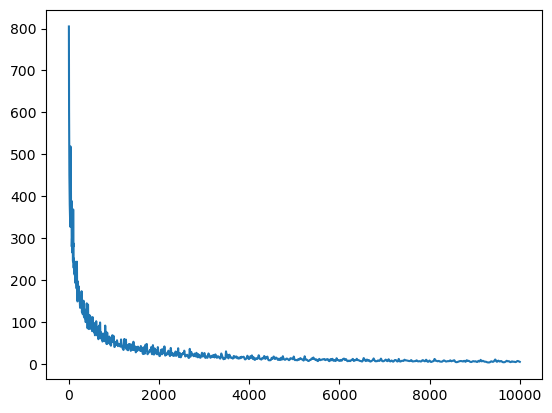

In [275]:
plt.plot(lossi)
plt.show()

### Step 3: Build the same MLP layer but with fully pytorch code (nn.Linear(), etc.)

In [276]:
# network dimensions
n_in = 784
n_hidden = 200
n_out = 10

In [291]:
train_input, train_target, test_input, test_target = load_data(one_hot_labels = True, normalize = True)
train_target *= 0.9
test_target *= 0.9
X_tr, Y_tr = train_input, train_target
X_test, Y_test = test_input, test_target

* Using MNIST
** Reduce the data-set (use --full for the full thing)
** Use 1000 train and 1000 test samples


In [292]:
class MLP(nn.Module):

    def __init__(self):
        super().__init__()
        self.layers = nn.ModuleList((nn.Linear(n_in, n_hidden), 
                                     nn.Linear(n_hidden, n_out)))

    def __call__(self, x):
        z1 = self.layers[0](x)
        h1 = sigma(z1)
        z2 = self.layers[1](h1)
        h2 = sigma(z2)
        return h2
    
    def __parameters__(self):
        return [p for layer in self.layers for p in layer.parameters()]

model = MLP()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

In [293]:
# training
num_epochs = 10000

for n in range(num_epochs):
    y_pred = model(X_tr)
    loss = loss_fn(y_pred, Y_tr)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if n % 1000 == 0: 
        with torch.no_grad():
            # train accuracy
            acc_train = compute_accuracy(y_pred, Y_tr)
            # test accuracy
            y_test_preds = model(X_test)
            acc_test = compute_accuracy(y_test_preds, Y_test)
            print(f'step = {n:6d}\tloss={loss.item():.5f}\taccuracy (train, test): {acc_train:.5f}\t{acc_test:.5f}')

step =      0	loss=0.15629	accuracy (train, test): 0.12900	0.12300
step =   1000	loss=0.00010	accuracy (train, test): 1.00000	0.87300
step =   2000	loss=0.00003	accuracy (train, test): 1.00000	0.87100
step =   3000	loss=0.00019	accuracy (train, test): 1.00000	0.86700
step =   4000	loss=0.00007	accuracy (train, test): 1.00000	0.87400
step =   5000	loss=0.00001	accuracy (train, test): 1.00000	0.87200
step =   6000	loss=0.00006	accuracy (train, test): 1.00000	0.87600
step =   7000	loss=0.00008	accuracy (train, test): 1.00000	0.87100
step =   8000	loss=0.00006	accuracy (train, test): 1.00000	0.87300
step =   9000	loss=0.00000	accuracy (train, test): 1.00000	0.87200


##### Exercise: try to improve accuracy!

In [294]:
#the accuracy on the train sample is already at 1.
#but we can use the methods seen is class to improve the accuracy on test sample
#Regularization methods: SGD instead of GD (thanks to more implicit
# regularization with batch) dropout, batch normalization, penalty on loss (=weight decay),


#+ test diff step/ batch on SGD on MNIST and see how small batches /big step regularizes more 